# Import packages

In [30]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import regex as re
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx 
from collections import Counter
from fa2 import ForceAtlas2
from DataCleaningFunctions import DataCleaner, DataCollection, DataProcesser

# Data Collection 

In [2]:
params = {
        "thriller": {"years": ["2020s","2010s", "2000s"],
                "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],[[]]]}, 
        "action": {"years": ["2020s","2010s", "2000s"],
                "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],["2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"]]},             
        "comedy": {"years": ["2020s","2010s", "2000s"],
                "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],["2000", "2001", "2002","2003","2004","2005","2006","2007"]]},
        "adventure": {"years": ["2010s", "2000s"],
                "sub_years": [["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019", "2020", "2021", "2022"], ["2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"]]}, 
        "horror": {"years": ["2020", "2021", "2022", "2010","2011","2012","2013","2014","2015","2016","2017","2018","2019", "2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"], 
                "sub_years": [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]},
        "fantasy": {"years": ["2020s","2010s", "2000s"],
                "sub_years": [[[]],[[]],[[]]]}, 
        "science_fiction": {"years": ["2020s", "2010s", "2000s"],
                "sub_years": [[[]],[[]],[[]]]}, 
        }

data_collection = DataCollection()
data_movie_artist = pd.DataFrame()
for genre in params.keys():
    for years, sub_years in zip(params[genre]["years"],params[genre]["sub_years"]):
        data = data_collection.collect_movies_artist_data(genre, years, sub_years)
        data_movie_artist = pd.concat([data_movie_artist, data]) 

data_movie_artist = data_movie_artist.reset_index(drop=True)
#data_movie_artist.to_csv('data_movie_artist.csv', index=False)

In [3]:
#data_movie_artist = pd.read_csv('data_movie_artist.csv')
data_movie_artist.shape

(7415, 7)

# Data Cleaning

In [4]:
data_cleaner = DataCleaner(data_movie_artist)
data_cleaner.clean_columns()
data_movie_artist_cleaned = data_cleaner.data

In [5]:
data_movie_artist_cleaned.shape

(5724, 7)

In [6]:
data_movie_artist_cleaned.head(2)

,Title,Director,Cast,Country,Genre,Year,Hyperref
0,365 Days,barbara biaowas tomasz mandes,"anna-maria sieklucka,michele morrone, bronisaw...",europe,thriller,2020,365_Days_(2020_film)
1,7500,patrick vollrath,"joseph gordon-levitt,aylin tezel",other,action-thriller,2020,7500_(film)


In [29]:
data_movie_artist_cleaned

,Title,Director,Cast,Country,Genre,Year,Hyperref
0,365 Days,barbara biaowas tomasz mandes,"[anna-maria sieklucka, michele morrone, broni...",europe,thriller,2020,365_Days_(2020_film)
1,7500,patrick vollrath,"[joseph gordon-levitt, aylin tezel]",other,action-thriller,2020,7500_(film)
2,Archenemy,adam egypt mortimer,"[joe manganiello, skylan brooks, zolee griggs...",united states united kingdom,action-thriller,2020,Archenemy_(film)
3,Asuraguru,a raajdheep,"[vikram prabhu, mahima nambiar, subbaraju, yog...",india,action-thriller,2020,Asuraguru
4,Aswathama,ramana teja,"[naga shourya, mehreen pirzada]",india,action-thriller,2020,Aswathama_(film)
...,...,...,...,...,...,...,...
5719,Renegades,steven quale,"[sullivan stapleton, j. k. simmons, charlie be...",france,action-adventure,2017,Renegades_(2017_film)
5720,Scott Pilgrim vs the World,edgar wright,"[michael cera, mary elizabeth winstead, kieran...",united states,action-comedy,2010,Scott_Pilgrim_vs._the_World
5721,Skin Trade,ekachai uekrongtham,"[dolph lundgren, tony jaa, michael jai white, ...",united states,action-thriller,2014,Skin_Trade_(film)
5722,The League of Extraordinary Gentlemen,stephen norrington,"[sean connery, shane west, stuart townsend]",united states,other,2003,The_League_of_Extraordinary_Gentlemen_(film)


# test 

In [36]:
df_movies = data_movie_artist_cleaned.copy()

def find_connected_movies(movie, cast, df):
    # Find movies that share at least one cast member and are not the same movie
    connected_movies = df[df.apply(lambda x: any(actor in x['Cast'] for actor in cast) and x['Title'] != movie, axis=1)]
    return connected_movies['Title'].tolist()

# Create a new DataFrame for the results
results = []

for index, row in df_movies.iterrows():
    movie = row['Title']
    cast = row['Cast']
    connected = find_connected_movies(movie, cast, df_movies)
    results.append({'Movie': movie, 'Connected Movies': connected, 'Casts in the Movie': cast})

df_results = pd.DataFrame(results)



In [56]:
df_movies

,Title,Director,Cast,Country,Genre,Year,Hyperref
0,365 Days,barbara biaowas tomasz mandes,"[anna-maria sieklucka, michele morrone, broni...",europe,thriller,2020,365_Days_(2020_film)
1,7500,patrick vollrath,"[joseph gordon-levitt, aylin tezel]",other,action-thriller,2020,7500_(film)
2,Archenemy,adam egypt mortimer,"[joe manganiello, skylan brooks, zolee griggs...",united states united kingdom,action-thriller,2020,Archenemy_(film)
3,Asuraguru,a raajdheep,"[vikram prabhu, mahima nambiar, subbaraju, yog...",india,action-thriller,2020,Asuraguru
4,Aswathama,ramana teja,"[naga shourya, mehreen pirzada]",india,action-thriller,2020,Aswathama_(film)
...,...,...,...,...,...,...,...
5719,Renegades,steven quale,"[sullivan stapleton, j. k. simmons, charlie be...",france,action-adventure,2017,Renegades_(2017_film)
5720,Scott Pilgrim vs the World,edgar wright,"[michael cera, mary elizabeth winstead, kieran...",united states,action-comedy,2010,Scott_Pilgrim_vs._the_World
5721,Skin Trade,ekachai uekrongtham,"[dolph lundgren, tony jaa, michael jai white, ...",united states,action-thriller,2014,Skin_Trade_(film)
5722,The League of Extraordinary Gentlemen,stephen norrington,"[sean connery, shane west, stuart townsend]",united states,other,2003,The_League_of_Extraordinary_Gentlemen_(film)


In [37]:
df_results

,Movie,Connected Movies,Casts in the Movie
0,365 Days,[365 Days This Day],"[anna-maria sieklucka, michele morrone, broni..."
1,7500,"[Looper, Premium Rush, Sin City A Dame to Kill...","[joseph gordon-levitt, aylin tezel]"
2,Archenemy,"[No Sudden Move, Sabotage, The Sleepover, The ...","[joe manganiello, skylan brooks, zolee griggs..."
3,Asuraguru,[Cocktail ra vijaya murugan],"[vikram prabhu, mahima nambiar, subbaraju, yog..."
4,Aswathama,[],"[naga shourya, mehreen pirzada]"
...,...,...,...
5719,Renegades,"[The Accountant, Palm Springs, Juno, Hammer of...","[sullivan stapleton, j. k. simmons, charlie be..."
5720,Scott Pilgrim vs the World,"[No Sudden Move, Birds of Prey, Kate, Paws of ...","[michael cera, mary elizabeth winstead, kieran..."
5721,Skin Trade,"[Monster Hunter, Nightmare Alley, Batman Soul ...","[dolph lundgren, tony jaa, michael jai white, ..."
5722,The League of Extraordinary Gentlemen,"[Trapped, Chaos Theory, Mid Century, Queen of ...","[sean connery, shane west, stuart townsend]"


# Basic Statistics

### Genre distribution

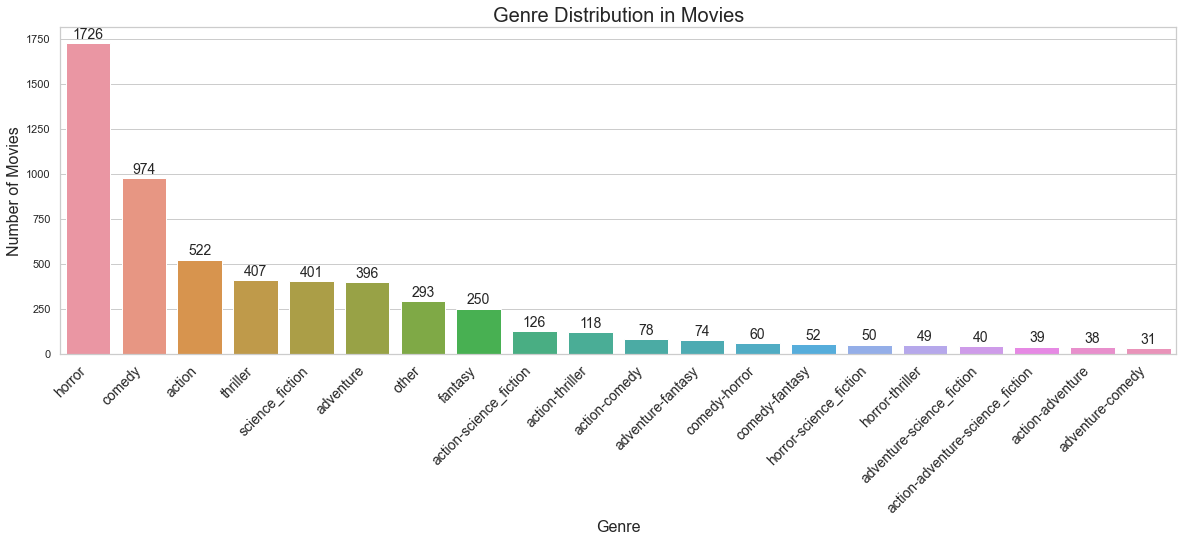

In [23]:
genre_counts = data_movie_artist_cleaned['Genre'].value_counts()
genre_counts = genre_counts.reset_index()
genre_counts.columns = ['Genre', 'Count']

# Create the bar plot
sns.set(style="whitegrid") 
plt.figure(figsize=(20, 6)) 
barplot = sns.barplot(x='Genre', y='Count', data=genre_counts)

# Rotate the labels on x-axis for better readability
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.title('Genre Distribution in Movies', fontsize=20)
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Number of Movies', fontsize=16)

# Add count numbers on each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points',
                     fontsize=14)
plt.show()

### Movies over time 

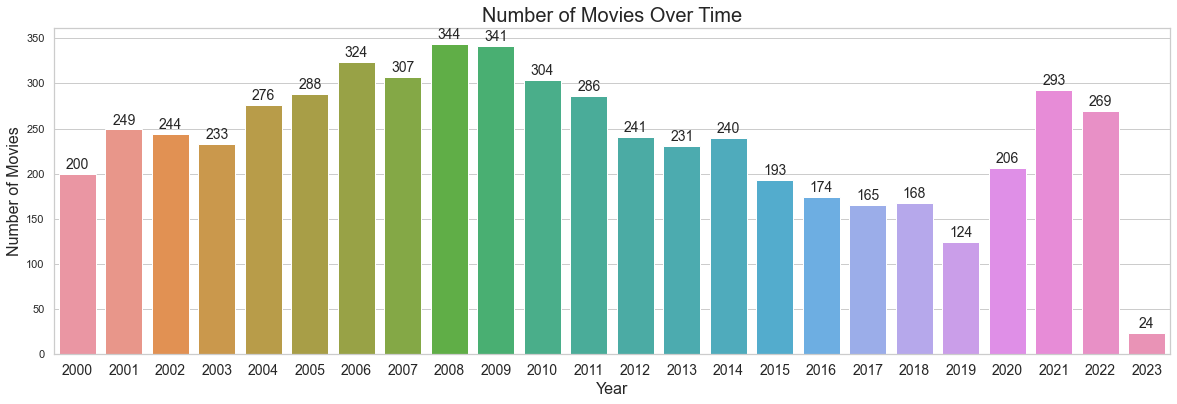

In [24]:
data_movie_artist_cleaned['Year'] = pd.to_numeric(data_movie_artist_cleaned['Year'], errors='coerce')
movies_per_year = data_movie_artist_cleaned.groupby('Year').size()
movies_per_year = movies_per_year.reset_index()
movies_per_year.columns = ['Year', 'Number of Movies']

# Create the bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x='Year', y='Number of Movies', data=movies_per_year)
plt.xticks(fontsize=14)
plt.title('Number of Movies Over Time', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Movies', fontsize=16)

# Add count numbers on each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points',
                     fontsize=14)
plt.show()

### Country distribution

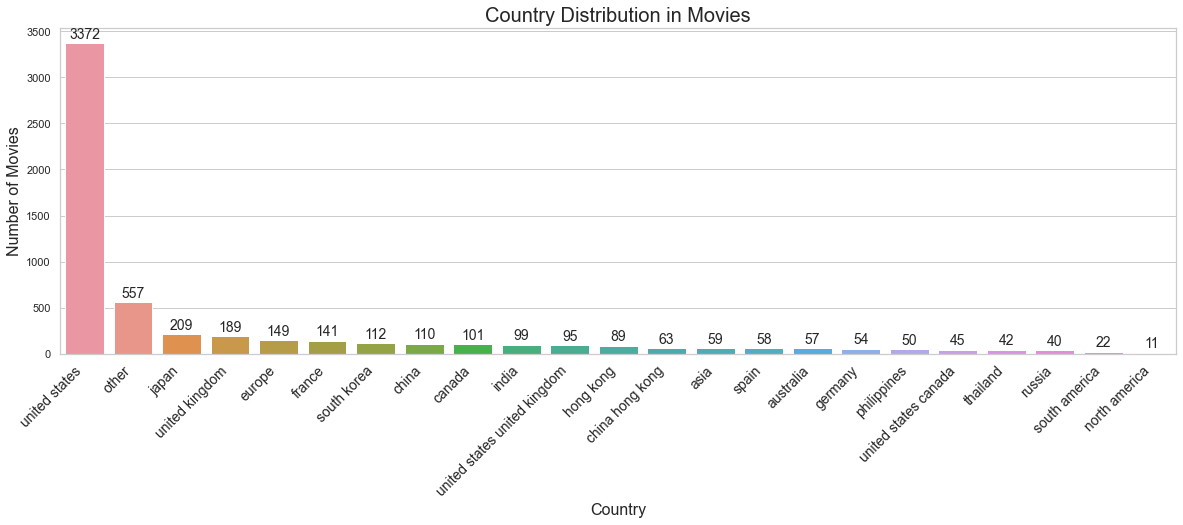

In [25]:
genre_counts = data_movie_artist_cleaned['Country'].value_counts()
genre_counts = genre_counts.reset_index()
genre_counts.columns = ['Country', 'Count']

# Create the bar plot
sns.set(style="whitegrid") 
plt.figure(figsize=(20, 6)) 
barplot = sns.barplot(x='Country', y='Count', data=genre_counts)

# Rotate the labels on x-axis for better readability
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.title('Country Distribution in Movies', fontsize=20)
plt.xlabel('Country', fontsize=16)
plt.ylabel('Number of Movies', fontsize=16)

# Add count numbers on each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points',
                     fontsize=14)
plt.show()

# Network Science

### Creating undirected graph with nodes as artists and edges between artists that have collaborated in movie together

In [40]:
# # Create undirected Graph
G_artist = nx.Graph()

# Adding nodes
all_artist_nodes = list(list(df_results['Movie'].unique()))
G_artist.add_nodes_from(all_artist_nodes)

# Adding edges
for movie, connected_movies in zip(df_results['Movie'], df_results['Connected Movies']):
    G_artist.add_edges_from([(movie, col) for col in connected_movies])

In [61]:
node_attr = df_movies[['Title', 'Genre', 'Year']].set_index('Title').to_dict('index') 
nx.set_node_attributes(G_artist, node_attr) #Adding attributes to the graph

In [62]:
print("The network consist of: ", G_artist.number_of_edges(), " links")
print("The network consist of: ", G_artist.number_of_nodes(), " nodes (Movies)")

The network consist of:  34940  links
The network consist of:  5724  nodes (Movies)


In [43]:
# # Initialize the graph
# G_artist = nx.Graph()

# # Add nodes
# all_artist_nodes = list(list(artist_collaboration_df['Cast'].unique()))
# G_artist.add_nodes_from(all_artist_nodes)

# # Initialize a Counter to keep track of collaborations
# collaboration_counter = Counter()

# # Update the Counter with each collaboration
# for artist, collaborators in zip(artist_collaboration_df['Cast'], artist_collaboration_df['connected']):
#     for collaborator in collaborators:
#         if artist != collaborator:
#             collaboration_pair = tuple(sorted([artist, collaborator]))
#             collaboration_counter[collaboration_pair] += 1

# # Add weighted edges to the graph
# for (artist1, artist2), weight in collaboration_counter.items():
#     G_artist.add_edge(artist1, artist2, weight=weight)


In [63]:
print("The average degree of the GCC is:", round(sum(dict(G_artist.degree()).values())/len(G_artist.degree)))

The average degree of the GCC is: 12


### Extracting the largest component

In [64]:
#Extracting the largest component
connected_components = nx.connected_components(G_artist)
# Finding the largest connected component
largest_cc = max(connected_components, key=len)
# Creating a subgraph for the largest connected component
G_largest_cc = G_artist.subgraph(largest_cc).copy()

In [65]:
print("The largest connected component network consist of: ", G_largest_cc.number_of_edges(), " links")
print("The largest connected component network consist of: ", G_largest_cc.number_of_nodes(), " nodes (Movies)")

The largest connected component network consist of:  34562  links
The largest connected component network consist of:  4187  nodes (Movies)


In [66]:
print("The average degree of the GCC is:", round(sum(dict(G_largest_cc.degree()).values())/len(G_largest_cc.degree)))

The average degree of the GCC is: 17


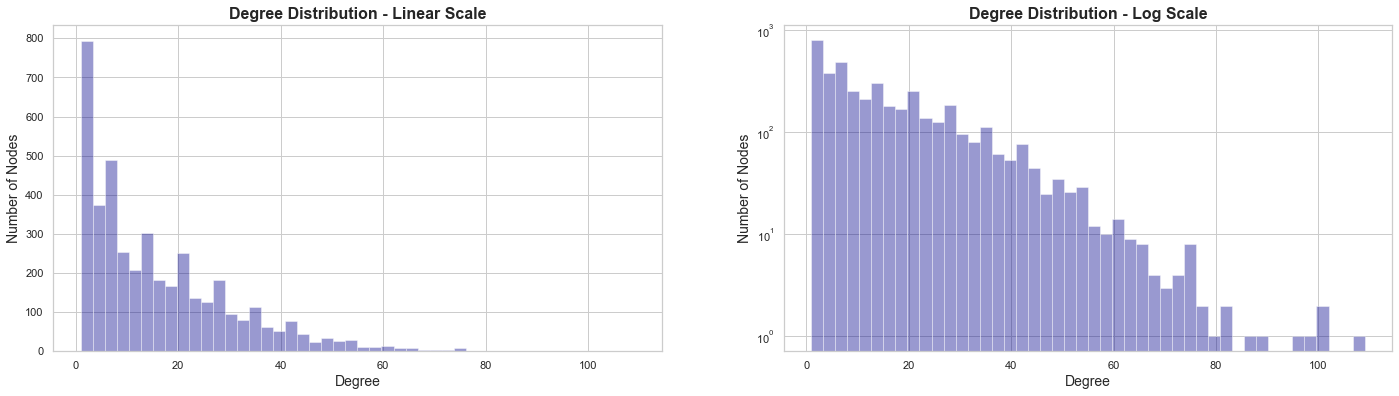

In [47]:
# Calculating degrees for each node
degrees = [G_largest_cc.degree(n) for n in G_largest_cc.nodes()]

# Convert the degrees list to a DataFrame
degrees_df = pd.DataFrame(degrees, columns=['Degree'])

# Set up the matplotlib figure
plt.figure(figsize=(24, 6))

# First subplot for the regular scale histogram
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.distplot(degrees_df['Degree'], kde=False, color='darkblue', hist_kws={'edgecolor':'white'})
plt.title('Degree Distribution - Linear Scale', fontweight="bold", fontsize=16)
plt.xlabel('Degree', fontsize=14)
plt.ylabel('Number of Nodes', fontsize=14)

# Second subplot for the logarithmic scale histogram
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.distplot(degrees_df['Degree'], kde=False, color='darkblue', hist_kws={'edgecolor':'white'})
plt.title('Degree Distribution - Log Scale', fontweight="bold", fontsize=16)
plt.xlabel('Degree', fontsize=14)
plt.ylabel('Number of Nodes', fontsize=14)
plt.yscale('log')

# Show the plot
plt.show()


### Top connected artists

In [48]:
degrees = dict(G_largest_cc.degree())
degrees_artists = {node: degree for node, degree in degrees.items()}
top_connected = sorted(degrees_artists, key=degrees_artists.get, reverse=True)[:5]
print("Top 5 connected artists: ", top_connected)


Top 5 connected artists:  ['Amsterdam', 'Don t Look Up', 'Thor Love and Thunder', 'Avengers Endgame', 'Dolittle']


### Plot the network

In [221]:
# The Force Atlas 2 algorithm
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs  # (NOT IMPLEMENTED)
                        linLogMode=False,   # (NOT IMPLEMENTED)
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=5.0,

                        # Performance
                        jitterTolerance=0.6,  # Not above 1. 1 is more precise
                        barnesHutOptimize=True,
                        barnesHutTheta=1, # Try 2
                        multiThreaded=False ,  # (NOT IMPLEMENTED)

                        # Tuning
                        scalingRatio=10.0, # Greater number equals less sparse graph
                        strongGravityMode=True,
                        gravity=1500, # Try 1000 is somewhat round but 2000 is very round

                        # Log
                        verbose=True)


In [222]:
positions = forceatlas2.forceatlas2_networkx_layout(G_largest_cc, pos=None, iterations=1000)

100%|██████████| 1000/1000 [01:34<00:00, 10.62it/s]

BarnesHut Approximation  took  20.05  seconds
Repulsion forces  took  70.77  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  1.17  seconds
AdjustSpeedAndApplyForces step  took  0.77  seconds


In [224]:
#Setting up node sizes (depends on degree)
d = dict(G_largest_cc.degree)
deg_size = [v * 3 for v in d.values()]

In [225]:
#Setting up node colors (depends on genre)
nodes_color = []
for node in G_largest_cc.nodes.data():
    if node[1]['Genre'] == 'horror':
        nodes_color.append('red')
    elif (node[1]['Genre'] == 'action'):
        nodes_color.append('#DA70D6')
    elif (node[1]['Genre'] == 'comedy'):
        nodes_color.append('blue')
    elif (node[1]['Genre'] == 'thriller'):
        nodes_color.append('#008080')
    elif (node[1]['Genre'] == 'science_fiction'):
        nodes_color.append('#4B0082')
    elif (node[1]['Genre'] == 'adventure'):
        nodes_color.append('yellow')
    elif (node[1]['Genre'] == 'fantasy'):
        nodes_color.append('orange')
    else:
        nodes_color.append('pink')

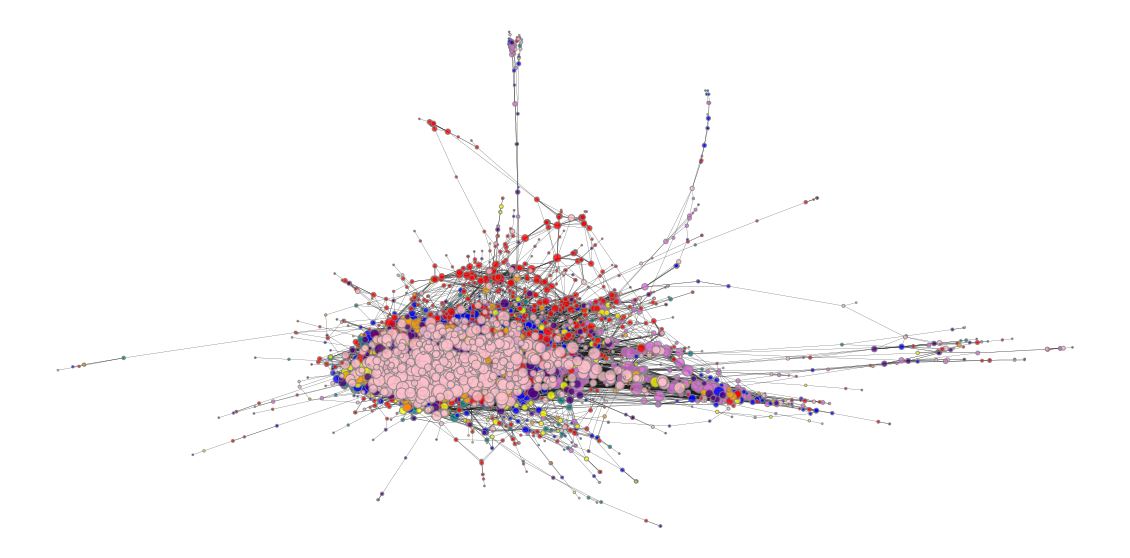

In [226]:
plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(G_largest_cc, positions, node_size=deg_size, node_color=nodes_color, alpha=0.80, edgecolors='grey')
nx.draw_networkx_edges(G_largest_cc, positions, width = 0.2)#, edge_color=edge_colors,width=0.5)
plt.axis('off')
plt.show()